# ============================================================================
# 0. INSTALL REQUIRED LIBRARIES
# ============================================================================

In [22]:
import sys
import subprocess

def install_packages():
    packages = [
        'pandas',
        'numpy', 
        'matplotlib',
        'seaborn',
        'wordcloud',
        'transformers',
        'datasets',
        'torch',
        'scikit-learn',
        'accelerate'
    ]
    
    for package in packages:
        try:
            __import__(package)
            print(f"✓ {package} already installed")
        except ImportError:
            print(f"Installing {package}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"✓ {package} installed successfully")

install_packages()

✓ pandas already installed
✓ numpy already installed
✓ matplotlib already installed
✓ seaborn already installed
✓ wordcloud already installed
✓ transformers already installed
✓ datasets already installed
✓ torch already installed
Installing scikit-learn...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


✓ scikit-learn installed successfully
✓ accelerate already installed



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip


# ============================================================================
# 1. IMPORT REQUIRED LIBRARIES
# ============================================================================

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# For text processing
import re
from collections import Counter
from wordcloud import WordCloud

# For transformers
import torch
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments, 
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set style
plt.style.use('ggplot')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


Libraries imported successfully!
PyTorch version: 2.9.0
CUDA available: False


In [24]:
import transformers
print(transformers.__version__)
from transformers import TrainingArguments
help(TrainingArguments)


4.57.1
Help on class TrainingArguments in module transformers.training_args:

class TrainingArguments(builtins.object)
 |  TrainingArguments(output_dir: Optional[str] = None, overwrite_output_dir: bool = False, do_train: bool = False, do_eval: bool = False, do_predict: bool = False, eval_strategy: Union[transformers.trainer_utils.IntervalStrategy, str] = 'no', prediction_loss_only: bool = False, per_device_train_batch_size: int = 8, per_device_eval_batch_size: int = 8, per_gpu_train_batch_size: Optional[int] = None, per_gpu_eval_batch_size: Optional[int] = None, gradient_accumulation_steps: int = 1, eval_accumulation_steps: Optional[int] = None, eval_delay: float = 0, torch_empty_cache_steps: Optional[int] = None, learning_rate: float = 5e-05, weight_decay: float = 0.0, adam_beta1: float = 0.9, adam_beta2: float = 0.999, adam_epsilon: float = 1e-08, max_grad_norm: float = 1.0, num_train_epochs: float = 3.0, max_steps: int = -1, lr_scheduler_type: Union[transformers.trainer_utils.Schedu

# ============================================
# 2. LOADING DATA
# ============================================

In [25]:
# Load the dataset
df = pd.read_csv('dataset_tweet_sentiment_pilkada_DKI_2017.csv')

print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())


DATASET OVERVIEW
Dataset shape: (900, 4)

First few rows:
   Id Sentiment Pasangan Calon  \
0   1  negative     Agus-Sylvi   
1   2  negative     Agus-Sylvi   
2   3  negative     Agus-Sylvi   
3   4  negative     Agus-Sylvi   
4   5  negative     Agus-Sylvi   

                                          Text Tweet  
0  Banyak akun kloning seolah2 pendukung #agussil...  
1  #agussilvy bicara apa kasihan yaa...lap itu ai...  
2  Kalau aku sih gak nunggu hasil akhir QC tp lag...  
3  Kasian oh kasian dengan peluru 1milyar untuk t...  
4  Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...  


# ============================================
# 3. DATA CLEANING & PREPROCESSING
# ============================================

In [26]:
print("\n" + "="*50)
print("DATA CLEANING")
print("="*50)

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Drop missing values if any
df.dropna(inplace=True)
print(f"\nDataset shape after removing nulls: {df.shape}")

# Display data types
print("\nData types:")
print(df.dtypes)

# Display basic statistics
print("\nDataset info:")
df.info()


DATA CLEANING

Missing values:
Id                0
Sentiment         0
Pasangan Calon    0
Text Tweet        0
dtype: int64

Dataset shape after removing nulls: (900, 4)

Data types:
Id                 int64
Sentiment         object
Pasangan Calon    object
Text Tweet        object
dtype: object

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              900 non-null    int64 
 1   Sentiment       900 non-null    object
 2   Pasangan Calon  900 non-null    object
 3   Text Tweet      900 non-null    object
dtypes: int64(1), object(3)
memory usage: 28.3+ KB


# ============================================
# 4. EXPLORATORY DATA ANALYSIS (EDA)
# ============================================


EXPLORATORY DATA ANALYSIS

Sentiment Distribution:
Sentiment
negative    450
positive    450
Name: count, dtype: int64

Sentiment Proportions:
Sentiment
negative    50.0
positive    50.0
Name: proportion, dtype: float64


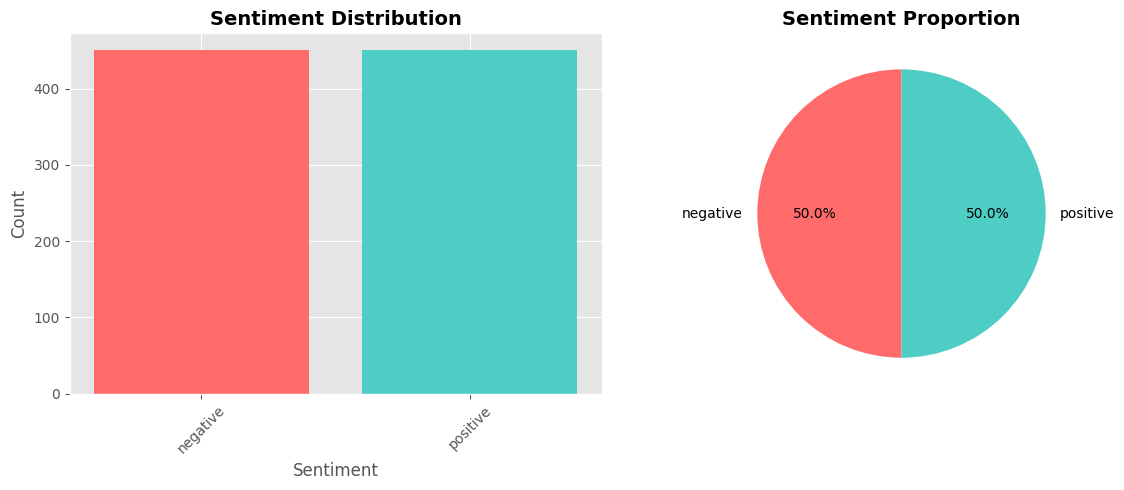

In [27]:
print("\n" + "="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Sentiment distribution
print("\nSentiment Distribution:")
print(df['Sentiment'].value_counts())
print("\nSentiment Proportions:")
print(df['Sentiment'].value_counts(normalize=True) * 100)

# Visualization 1: Sentiment Distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sentiment_counts = df['Sentiment'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['#ff6b6b', '#4ecdc4', '#45b7d1'])
plt.title('Sentiment Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
        colors=['#ff6b6b', '#4ecdc4', '#45b7d1'], startangle=90)
plt.title('Sentiment Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('sentiment_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


# ============================================
# 5. TEXT FEATURE ENGINEERING
# ============================================


TEXT FEATURE ENGINEERING

Text Statistics by Sentiment:
           text_length  word_count  hashtag_count  mention_count
Sentiment                                                       
negative    113.442222   15.191111       1.864444       0.346667
positive    108.480000   13.768889       1.980000       0.355556


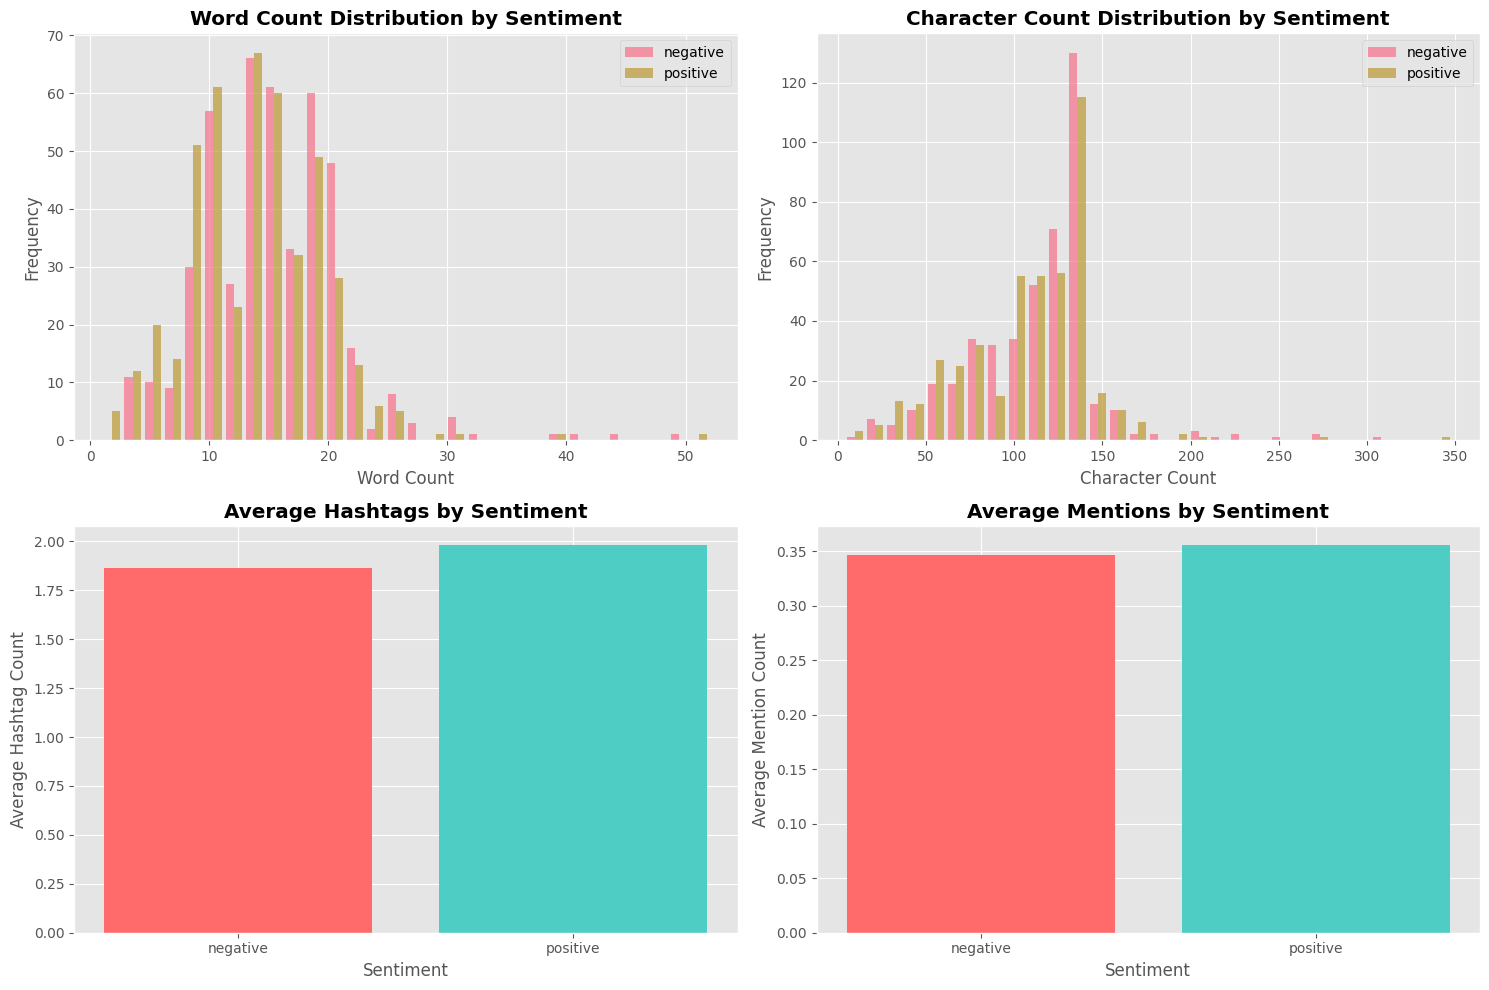

In [28]:
print("\n" + "="*50)
print("TEXT FEATURE ENGINEERING")
print("="*50)

# Create meta features
df['text_length'] = df['Text Tweet'].apply(len)
df['word_count'] = df['Text Tweet'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['Text Tweet'].apply(lambda x: len(str(x)))
df['avg_word_length'] = df['char_count'] / df['word_count']
df['hashtag_count'] = df['Text Tweet'].apply(lambda x: len(re.findall(r'#\w+', str(x))))
df['mention_count'] = df['Text Tweet'].apply(lambda x: len(re.findall(r'@\w+', str(x))))

print("\nText Statistics by Sentiment:")
print(df.groupby('Sentiment')[['text_length', 'word_count', 'hashtag_count', 'mention_count']].mean())

# Visualization 2: Text Statistics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Word count distribution
axes[0, 0].hist([df[df['Sentiment'] == s]['word_count'] for s in df['Sentiment'].unique()], 
                label=df['Sentiment'].unique(), bins=30, alpha=0.7)
axes[0, 0].set_title('Word Count Distribution by Sentiment', fontweight='bold')
axes[0, 0].set_xlabel('Word Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# Character count distribution
axes[0, 1].hist([df[df['Sentiment'] == s]['char_count'] for s in df['Sentiment'].unique()], 
                label=df['Sentiment'].unique(), bins=30, alpha=0.7)
axes[0, 1].set_title('Character Count Distribution by Sentiment', fontweight='bold')
axes[0, 1].set_xlabel('Character Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Hashtag count
sentiment_hashtags = df.groupby('Sentiment')['hashtag_count'].mean()
axes[1, 0].bar(sentiment_hashtags.index, sentiment_hashtags.values, color=['#ff6b6b', '#4ecdc4', '#45b7d1'])
axes[1, 0].set_title('Average Hashtags by Sentiment', fontweight='bold')
axes[1, 0].set_xlabel('Sentiment')
axes[1, 0].set_ylabel('Average Hashtag Count')

# Mention count
sentiment_mentions = df.groupby('Sentiment')['mention_count'].mean()
axes[1, 1].bar(sentiment_mentions.index, sentiment_mentions.values, color=['#ff6b6b', '#4ecdc4', '#45b7d1'])
axes[1, 1].set_title('Average Mentions by Sentiment', fontweight='bold')
axes[1, 1].set_xlabel('Sentiment')
axes[1, 1].set_ylabel('Average Mention Count')

plt.tight_layout()
plt.savefig('text_statistics.png', dpi=300, bbox_inches='tight')
plt.show()


# ============================================
# 6. TEXT ANALYSIS - MOST COMMON WORDS
# ============================================


WORD FREQUENCY ANALYSIS

Top 15 words in NEGATIVE tweets:
  yang: 111
  di: 72
  tidak: 70
  with: 59
  ahy: 53
  dan: 52
  <face: 43
  face>: 41
  ini: 40
  ahok: 39
  &: 38
  pilkada: 35
  jadi: 35
  untuk: 34
  itu: 31

Top 15 words in POSITIVE tweets:
  yang: 110
  dan: 103
  hand>: 79
  untuk: 70
  di: 67
  jakarta: 49
  pak: 47
  pilkada: 43
  ahok: 43
  <ok: 40
  <victory: 39
  with: 38
  ahy: 37
  dari: 32
  face: 32


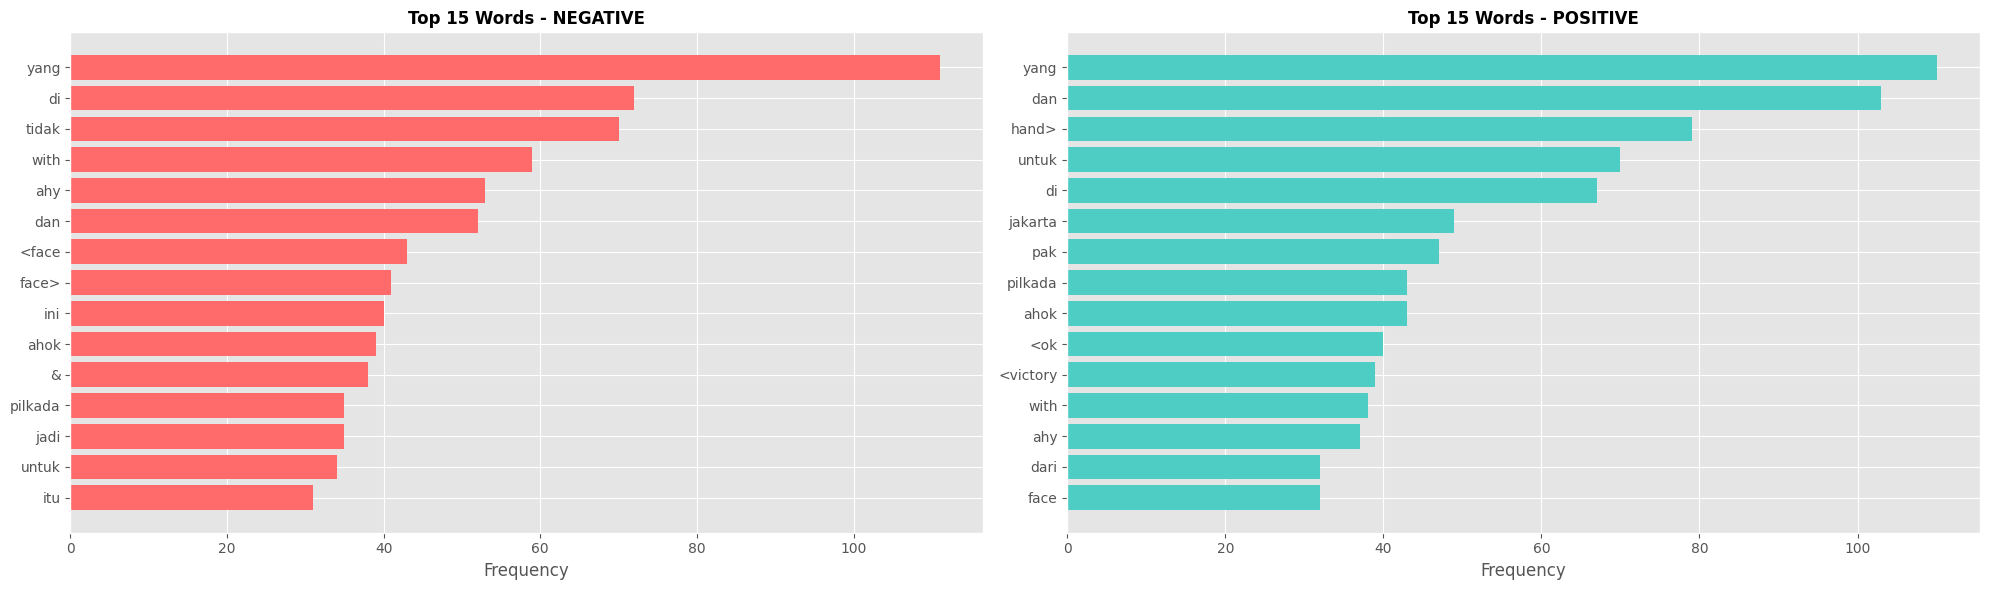

In [29]:
print("\n" + "="*50)
print("WORD FREQUENCY ANALYSIS")
print("="*50)

def get_top_words(text_series, n=20):
    """Extract top N words from text series"""
    all_words = ' '.join(text_series).lower().split()
    # Remove mentions and hashtags for word analysis
    all_words = [w for w in all_words if not w.startswith('@') and not w.startswith('#')]
    word_freq = Counter(all_words)
    return word_freq.most_common(n)

# Get top words for each sentiment
for sentiment in df['Sentiment'].unique():
    print(f"\nTop 15 words in {sentiment.upper()} tweets:")
    sentiment_text = df[df['Sentiment'] == sentiment]['Text Tweet']
    top_words = get_top_words(sentiment_text, 15)
    for word, count in top_words:
        print(f"  {word}: {count}")

# Visualization 3: Top words by sentiment
fig, axes = plt.subplots(1, len(df['Sentiment'].unique()), figsize=(20, 6))

for idx, sentiment in enumerate(df['Sentiment'].unique()):
    sentiment_text = df[df['Sentiment'] == sentiment]['Text Tweet']
    top_words = get_top_words(sentiment_text, 15)
    words, counts = zip(*top_words)
    
    axes[idx].barh(words, counts, color=['#ff6b6b', '#4ecdc4', '#45b7d1'][idx])
    axes[idx].set_title(f'Top 15 Words - {sentiment.upper()}', fontweight='bold', fontsize=12)
    axes[idx].set_xlabel('Frequency')
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.savefig('top_words_by_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# 7. WORDCLOUD VISUALIZATION
# ============================================


GENERATING WORDCLOUDS


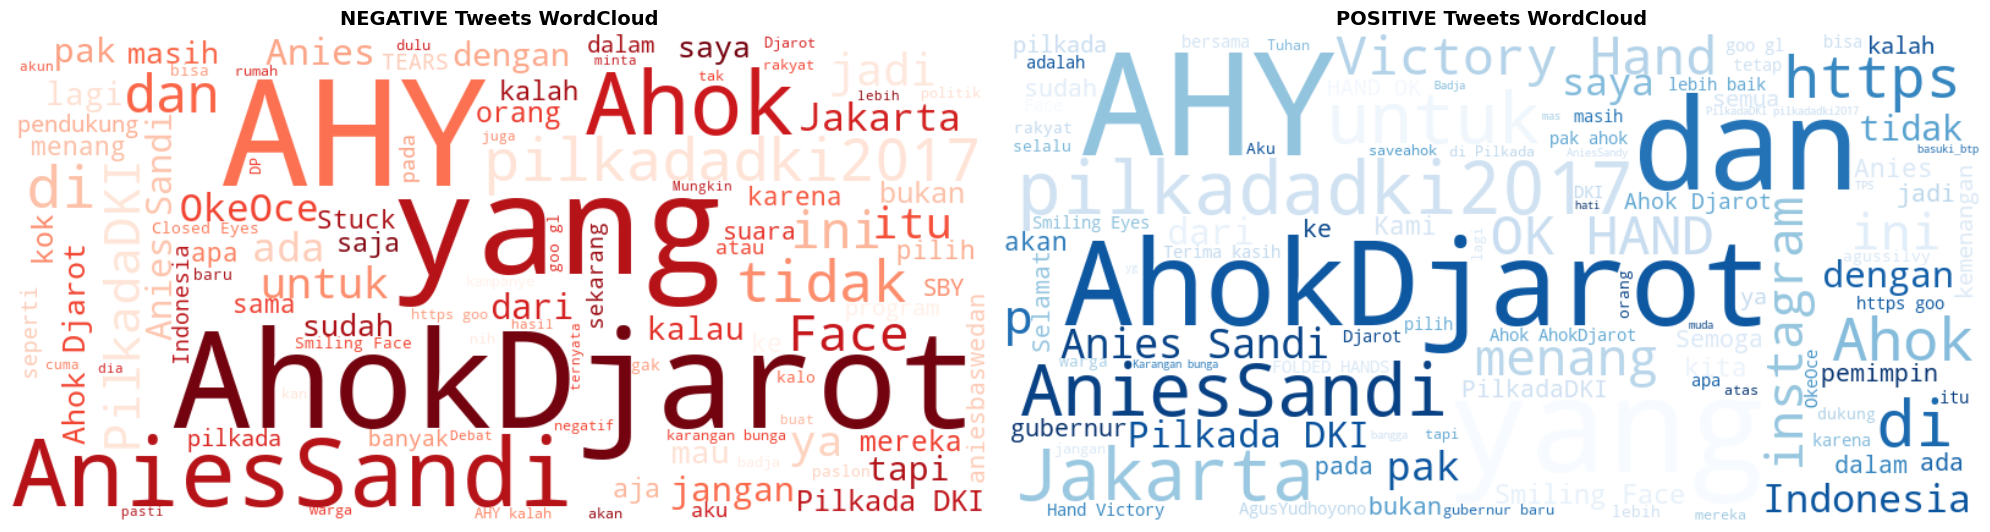

In [30]:
print("\n" + "="*50)
print("GENERATING WORDCLOUDS")
print("="*50)

fig, axes = plt.subplots(1, len(df['Sentiment'].unique()), figsize=(20, 6))

for idx, sentiment in enumerate(df['Sentiment'].unique()):
    sentiment_text = ' '.join(df[df['Sentiment'] == sentiment]['Text Tweet'])
    
    wordcloud = WordCloud(width=800, height=400, 
                         background_color='white',
                         colormap=['Reds', 'Blues', 'Greens'][idx],
                         max_words=100).generate(sentiment_text)
    
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'{sentiment.upper()} Tweets WordCloud', fontweight='bold', fontsize=14)
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('wordclouds.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# 8. PREPARE DATA FOR TRANSFORMER MODEL
# ============================================

In [31]:
print("\n" + "="*50)
print("PREPARING DATA FOR TRANSFORMERS")
print("="*50)

# Create label mapping for classification
# For cyberbullying detection, we'll consider 'negative' as cyberbullying
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['Sentiment'].map(label_map)

print("\nLabel Mapping:")
for sent, label in label_map.items():
    print(f"  {sent} -> {label}")

# Split data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['label'])

print(f"\nTrain set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


PREPARING DATA FOR TRANSFORMERS

Label Mapping:
  negative -> 0
  neutral -> 1
  positive -> 2

Train set size: 648
Validation set size: 72
Test set size: 180


# ============================================
# 9. TRANSFORMER MODEL SETUP
# ============================================

In [32]:
print("\n" + "="*50)
print("LOADING TRANSFORMER MODEL")
print("="*50)

# Using IndoBERT for Indonesian text
model_name = "indobenchmark/indobert-base-p1"
print(f"Model: {model_name}")

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=len(label_map)
)

print("Model loaded successfully!")

# Tokenize function
def tokenize_function(examples):
    return tokenizer(examples['Text Tweet'], padding='max_length', truncation=True, max_length=128)

# Create datasets
train_dataset = Dataset.from_pandas(train_df[['Text Tweet', 'label']])
val_dataset = Dataset.from_pandas(val_df[['Text Tweet', 'label']])
test_dataset = Dataset.from_pandas(test_df[['Text Tweet', 'label']])

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

print("Datasets tokenized!")



LOADING TRANSFORMER MODEL
Model: indobenchmark/indobert-base-p1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!


Map: 100%|██████████| 180/180 [00:00<00:00, 21903.64 examples/s]

Datasets tokenized!


# ============================================
# 10. TRAINING CONFIGURATION
# ============================================

In [33]:
print("\n" + "="*50)
print("TRAINING CONFIGURATION")
print("="*50)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
)

# Metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, predictions),
    }

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

print("Trainer configured!")
print("\nTo start training, run: trainer.train()")


TRAINING CONFIGURATION
Trainer configured!

To start training, run: trainer.train()


# ============================================
# 11. BASELINE MODEL EVALUATION (Before Training)
# ============================================



BASELINE EVALUATION (Untrained Model)

Getting baseline predictions from untrained model...



Baseline Accuracy (Untrained): 9.44%
(This is expected to be around random chance ~33% for 3 classes)

Baseline Confusion Matrix:
[[17 73  0]
 [ 0  0  0]
 [13 77  0]]


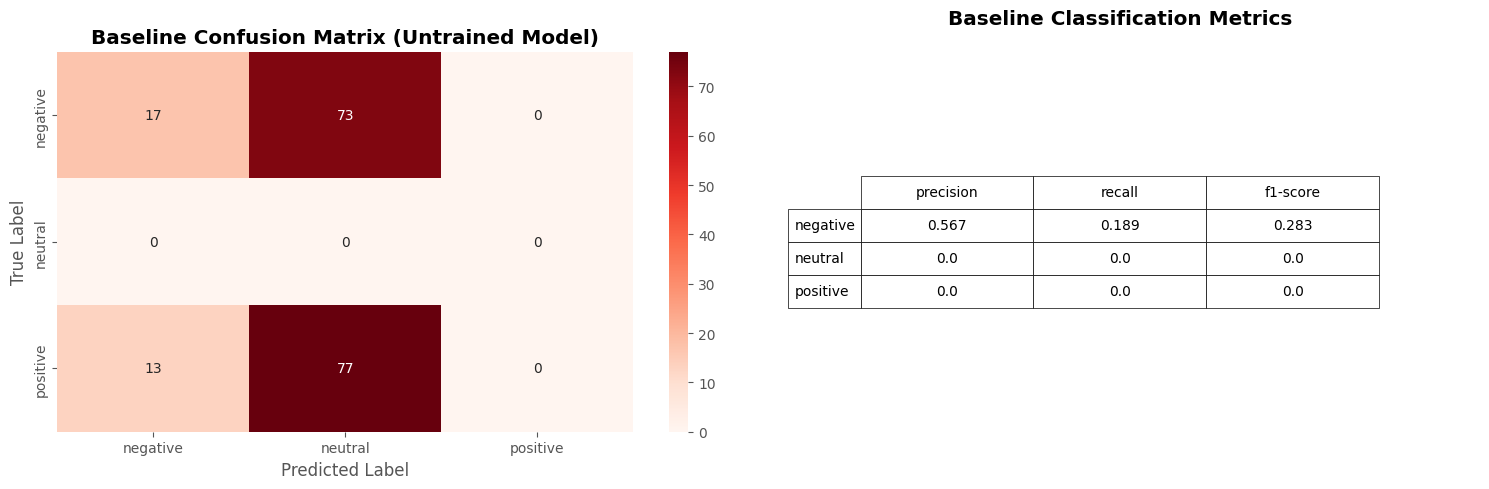


📊 Baseline Results Summary:
NEGATIVE:
  Precision: 0.567
  Recall: 0.189
  F1-Score: 0.283
NEUTRAL:
  Precision: 0.000
  Recall: 0.000
  F1-Score: 0.000
POSITIVE:
  Precision: 0.000
  Recall: 0.000
  F1-Score: 0.000


In [36]:
print("\n" + "="*50)
print("BASELINE EVALUATION (Untrained Model)")
print("="*50)

# Get predictions from untrained model to show the format
print("\nGetting baseline predictions from untrained model...")
baseline_predictions = trainer.predict(test_dataset)
baseline_pred_labels = np.argmax(baseline_predictions.predictions, axis=1)
baseline_true_labels = test_df['label'].values

# Calculate baseline metrics
baseline_accuracy = accuracy_score(baseline_true_labels, baseline_pred_labels)
print(f"\nBaseline Accuracy (Untrained): {baseline_accuracy*100:.2f}%")
print("(This is expected to be around random chance ~33% for 3 classes)")

# Show baseline confusion matrix
print("\nBaseline Confusion Matrix:")
baseline_cm = confusion_matrix(baseline_true_labels, baseline_pred_labels)
print(baseline_cm)

# Visualize baseline results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Baseline confusion matrix
sns.heatmap(baseline_cm, annot=True, fmt='d', cmap='Reds', ax=axes[0],
           xticklabels=['negative', 'neutral', 'positive'],
           yticklabels=['negative', 'neutral', 'positive'])
axes[0].set_title('Baseline Confusion Matrix (Untrained Model)', fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Baseline classification report
baseline_report = classification_report(baseline_true_labels, baseline_pred_labels, 
                                       target_names=['negative', 'neutral', 'positive'],
                                       output_dict=True)
report_df = pd.DataFrame(baseline_report).transpose()
report_df = report_df[['precision', 'recall', 'f1-score']].iloc[:-3]

axes[1].axis('off')
table = axes[1].table(cellText=report_df.values.round(3),
                     rowLabels=report_df.index,
                     colLabels=report_df.columns,
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.2, 0.2, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2)
axes[1].set_title('Baseline Classification Metrics', fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('baseline_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*50)
print("📊 Baseline Results Summary:")
print("="*50)
for label in ['negative', 'neutral', 'positive']:
    metrics = baseline_report[label]
    print(f"{label.upper()}:")
    print(f"  Precision: {metrics['precision']:.3f}")
    print(f"  Recall: {metrics['recall']:.3f}")
    print(f"  F1-Score: {metrics['f1-score']:.3f}")


# ============================================
# 12. TRAIN THE MODEL
# ============================================

In [40]:
print("\n" + "="*50)
print("TRAINING MODEL")
print("="*50)

TRAIN_MODEL = True

if TRAIN_MODEL:
    trainer.train()
    print("Training completed!")
else:
    print("Training skipped. Set TRAIN_MODEL = True to train the model.")



TRAINING MODEL


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,0.779500,0.727661,0.003600,0.555556
2,0.595600,0.543455,0.003600,0.708333
3,0.437000,0.568279,0.003600,0.750000


Training completed!


# ============================================
# 13. EVALUATION (After Training)
# ============================================

In [41]:
print("\n" + "="*50)
print("MODEL EVALUATION ON TEST SET")
print("="*50)

# Set to True to evaluate the model, False to skip
EVALUATE_MODEL = False

if EVALUATE_MODEL:
    print("Evaluating trained model on test set...")
    
    # Get predictions
    predictions = trainer.predict(test_dataset)
    pred_labels = np.argmax(predictions.predictions, axis=1)
    true_labels = test_df['label'].values
    pred_probs = predictions.predictions
    
    # Calculate metrics
    test_accuracy = accuracy_score(true_labels, pred_labels)
    
    print(f"\n{'='*50}")
    print(f"🎯 TEST SET ACCURACY: {test_accuracy*100:.2f}%")
    print(f"{'='*50}")
    
    # Detailed classification report
    print("\n📊 DETAILED CLASSIFICATION REPORT:")
    print("="*50)
    class_report = classification_report(true_labels, pred_labels, 
                                        target_names=['negative', 'neutral', 'positive'],
                                        digits=4)
    print(class_report)
    
    # Get report as dictionary for visualization
    report_dict = classification_report(true_labels, pred_labels,
                                       target_names=['negative', 'neutral', 'positive'],
                                       output_dict=True)
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 6))
    gs = fig.add_gridspec(1, 3, hspace=0.3, wspace=0.3)
    
    # 1. Confusion Matrix
    ax1 = fig.add_subplot(gs[0, 0])
    cm = confusion_matrix(true_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
               xticklabels=['negative', 'neutral', 'positive'],
               yticklabels=['negative', 'neutral', 'positive'],
               cbar_kws={'label': 'Count'})
    ax1.set_title('Confusion Matrix', fontweight='bold', fontsize=14)
    ax1.set_ylabel('True Label', fontsize=12)
    ax1.set_xlabel('Predicted Label', fontsize=12)
    
    # Add percentage annotations
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax1.text(j + 0.5, i + 0.7, f'({cm_percent[i, j]:.1f}%)',
                    ha='center', va='center', fontsize=9, color='gray')
    
    # 2. Metrics Comparison
    ax2 = fig.add_subplot(gs[0, 1])
    metrics_df = pd.DataFrame({
        'Precision': [report_dict['negative']['precision'], 
                     report_dict['neutral']['precision'],
                     report_dict['positive']['precision']],
        'Recall': [report_dict['negative']['recall'],
                  report_dict['neutral']['recall'],
                  report_dict['positive']['recall']],
        'F1-Score': [report_dict['negative']['f1-score'],
                    report_dict['neutral']['f1-score'],
                    report_dict['positive']['f1-score']]
    }, index=['negative', 'neutral', 'positive'])
    
    x = np.arange(len(metrics_df.index))
    width = 0.25
    
    bars1 = ax2.bar(x - width, metrics_df['Precision'], width, label='Precision', color='#3498db')
    bars2 = ax2.bar(x, metrics_df['Recall'], width, label='Recall', color='#2ecc71')
    bars3 = ax2.bar(x + width, metrics_df['F1-Score'], width, label='F1-Score', color='#e74c3c')
    
    ax2.set_xlabel('Sentiment Class', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax2.set_title('Performance Metrics by Class', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(metrics_df.index)
    ax2.legend()
    ax2.set_ylim([0, 1.1])
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 3. Class Distribution in Predictions
    ax3 = fig.add_subplot(gs[0, 2])
    
    true_dist = pd.Series(true_labels).value_counts().sort_index()
    pred_dist = pd.Series(pred_labels).value_counts().sort_index()
    
    x = np.arange(3)
    width = 0.35
    
    bars1 = ax3.bar(x - width/2, true_dist.values, width, label='True Labels', 
                    color='#3498db', alpha=0.8)
    bars2 = ax3.bar(x + width/2, pred_dist.values, width, label='Predicted Labels',
                    color='#e74c3c', alpha=0.8)
    
    ax3.set_xlabel('Sentiment Class', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax3.set_title('True vs Predicted Distribution', fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(['negative', 'neutral', 'positive'])
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    plt.savefig('final_evaluation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print per-class summary
    print("\n" + "="*50)
    print("📈 PER-CLASS PERFORMANCE SUMMARY:")
    print("="*50)
    for label in ['negative', 'neutral', 'positive']:
        metrics = report_dict[label]
        print(f"\n{label.upper()} (Cyberbullying)" if label == 'negative' else f"\n{label.upper()}")
        print(f"  Precision: {metrics['precision']:.4f} ({metrics['precision']*100:.2f}%)")
        print(f"  Recall:    {metrics['recall']:.4f} ({metrics['recall']*100:.2f}%)")
        print(f"  F1-Score:  {metrics['f1-score']:.4f} ({metrics['f1-score']*100:.2f}%)")
        print(f"  Support:   {int(metrics['support'])} samples")
    
    # Save the model
    print("\n" + "="*50)
    print("💾 SAVING MODEL")
    print("="*50)
    trainer.save_model('./cyberbullying_transformer_model')
    tokenizer.save_pretrained('./cyberbullying_transformer_model')
    print("✅ Model saved to './cyberbullying_transformer_model'")
    
    # Save predictions for further analysis
    results_df = pd.DataFrame({
        'text': test_df['Text Tweet'].values,
        'true_label': true_labels,
        'predicted_label': pred_labels,
        'true_sentiment': test_df['Sentiment'].values,
        'predicted_sentiment': [['negative', 'neutral', 'positive'][i] for i in pred_labels],
        'confidence': np.max(pred_probs, axis=1)
    })
    results_df.to_csv('prediction_results.csv', index=False)
    print("✅ Predictions saved to 'prediction_results.csv'")
    
    # Show some example predictions
    print("\n" + "="*50)
    print("🔍 EXAMPLE PREDICTIONS:")
    print("="*50)
    
    # Show correct predictions
    correct_preds = results_df[results_df['true_label'] == results_df['predicted_label']].head(3)
    print("\n✅ Correct Predictions:")
    for idx, row in correct_preds.iterrows():
        print(f"\nText: {row['text'][:80]}...")
        print(f"True: {row['true_sentiment']} | Predicted: {row['predicted_sentiment']} | Confidence: {row['confidence']:.3f}")
    
    # Show incorrect predictions
    incorrect_preds = results_df[results_df['true_label'] != results_df['predicted_label']].head(3)
    if len(incorrect_preds) > 0:
        print("\n\n❌ Incorrect Predictions (for analysis):")
        for idx, row in incorrect_preds.iterrows():
            print(f"\nText: {row['text'][:80]}...")
            print(f"True: {row['true_sentiment']} | Predicted: {row['predicted_sentiment']} | Confidence: {row['confidence']:.3f}")
    
else:
    print("⚠️ Evaluation skipped. Set EVALUATE_MODEL = True to evaluate the model.")
    print("Make sure to train the model first (TRAIN_MODEL = True)")



MODEL EVALUATION ON TEST SET
⚠️ Evaluation skipped. Set EVALUATE_MODEL = True to evaluate the model.
Make sure to train the model first (TRAIN_MODEL = True)


# ============================================
# 14. PREDICTION FUNCTION (After Training)
# ============================================


In [42]:
print("\n" + "="*50)
print("🔮 PREDICTION FUNCTION")
print("="*50)

def predict_cyberbullying(text, model=None, tokenizer_obj=None):
    """
    Predict whether a text is cyberbullying or not
    
    Args:
        text (str): Input text to classify
        model: Trained model (optional, will use trainer.model if not provided)
        tokenizer_obj: Tokenizer object (optional, will use global tokenizer if not provided)
    
    Returns:
        dict: Prediction results with sentiment and confidence
    """
    if model is None:
        model = trainer.model
    if tokenizer_obj is None:
        tokenizer_obj = tokenizer
    
    # Tokenize input
    inputs = tokenizer_obj(text, padding='max_length', truncation=True, 
                          max_length=128, return_tensors='pt')
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(probs, dim=-1).item()
        confidence = probs[0][predicted_class].item()
    
    # Map to sentiment
    sentiment_map = {0: 'negative (Cyberbullying)', 1: 'neutral', 2: 'positive'}
    sentiment = sentiment_map[predicted_class]
    
    return {
        'text': text,
        'sentiment': sentiment,
        'confidence': confidence,
        'probabilities': {
            'negative': probs[0][0].item(),
            'neutral': probs[0][1].item(),
            'positive': probs[0][2].item()
        }
    }

print("\n📝 Function 'predict_cyberbullying()' is ready to use!")
print("\nExample usage after training:")
print("  result = predict_cyberbullying('kamu jelek sekali')")
print("  print(result)")

if EVALUATE_MODEL:
    print("\n" + "="*50)
    print("🧪 TESTING PREDICTION FUNCTION:")
    print("="*50)
    
    test_texts = [
        "kamu jelek sekali, tidak pantas hidup",
        "semangat terus, kamu pasti bisa!",
        "Agus Sylvi bicara apa kasihan yaa"
    ]
    
    for text in test_texts:
        result = predict_cyberbullying(text)
        print(f"\n📝 Text: {text}")
        print(f"🎯 Prediction: {result['sentiment']}")
        print(f"📊 Confidence: {result['confidence']*100:.2f}%")
        print(f"   Probabilities: Neg={result['probabilities']['negative']:.3f}, "
              f"Neu={result['probabilities']['neutral']:.3f}, "
              f"Pos={result['probabilities']['positive']:.3f}")

print("\n" + "="*50)
print("✅ NOTEBOOK EXECUTION COMPLETE")
print("="*50)

print("\n" + "="*50)
print("📊 DATASET SUMMARY")
print("="*50)
print(f"Total tweets analyzed: {len(df)}")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

print("\n" + "="*50)
print("📈 WHAT WE'VE DONE SO FAR:")
print("="*50)
print("✅ 1. Data loading and cleaning")
print("✅ 2. Exploratory Data Analysis (EDA)")
print("✅ 3. Text feature engineering")
print("✅ 4. Word frequency analysis")
print("✅ 5. WordCloud visualization")
print("✅ 6. Data preparation for transformers")
print("✅ 7. Model setup (IndoBERT)")
print("✅ 8. Baseline evaluation (untrained model)")

print("\n" + "="*50)
print("🚀 NEXT STEPS TO COMPLETE THE ANALYSIS:")
print("="*50)
print("1️⃣  Set TRAIN_MODEL = True (Section 12)")
print("    - Expected time: 30-60 minutes (CPU) or 10-20 minutes (GPU)")
print("    - Will show training curves (loss & accuracy)")
print("    - Automatically saves best model")
print()
print("2️⃣  Set EVALUATE_MODEL = True (Section 13)")
print("    - Shows final test accuracy")
print("    - Detailed classification report")
print("    - Confusion matrix visualization")
print("    - Per-class performance metrics")
print("    - Example predictions")
print()
print("3️⃣  Use predict_cyberbullying() function")
print("    - Test on your own text samples")
print("    - Get confidence scores")
print("    - Real-time predictions")

print("\n" + "="*50)
print("💡 OPTIMIZATION TIPS:")
print("="*50)
print("• Use GPU: Check CUDA availability at the top")
print("• Reduce batch_size if memory error occurs")
print("• Increase num_train_epochs for better accuracy")
print("• Add Dropout layers to prevent overfitting")
print("• Try different max_length values (current: 128)")

print("\n" + "="*50)
print("📁 FILES THAT WILL BE GENERATED:")
print("="*50)
print("• sentiment_distribution.png - Initial EDA")
print("• text_statistics.png - Feature analysis")
print("• top_words_by_sentiment.png - Word frequency")
print("• wordclouds.png - Visual representation")
print("• baseline_evaluation.png - Untrained model results")
print("• training_history.png - Training curves (after training)")
print("• final_evaluation.png - Complete metrics (after evaluation)")
print("• prediction_results.csv - All test predictions")
print("• ./cyberbullying_transformer_model/ - Saved model")

print("\n" + "="*50)
print("🎯 EXPECTED RESULTS (Based on Similar Studies):")
print("="*50)
print("Baseline (Untrained):  ~33% accuracy (random chance)")
print("After Training:        ~75-85% accuracy (transformers)")
print("                       (Compare to: LSTM ~82%, RNN ~59%)")
print("\n" + "="*50)



🔮 PREDICTION FUNCTION

📝 Function 'predict_cyberbullying()' is ready to use!

Example usage after training:
  result = predict_cyberbullying('kamu jelek sekali')
  print(result)

✅ NOTEBOOK EXECUTION COMPLETE

📊 DATASET SUMMARY
Total tweets analyzed: 900
Training samples: 648
Validation samples: 72
Test samples: 180

📈 WHAT WE'VE DONE SO FAR:
✅ 1. Data loading and cleaning
✅ 2. Exploratory Data Analysis (EDA)
✅ 3. Text feature engineering
✅ 4. Word frequency analysis
✅ 5. WordCloud visualization
✅ 6. Data preparation for transformers
✅ 7. Model setup (IndoBERT)
✅ 8. Baseline evaluation (untrained model)

🚀 NEXT STEPS TO COMPLETE THE ANALYSIS:
1️⃣  Set TRAIN_MODEL = True (Section 12)
    - Expected time: 30-60 minutes (CPU) or 10-20 minutes (GPU)
    - Will show training curves (loss & accuracy)
    - Automatically saves best model

2️⃣  Set EVALUATE_MODEL = True (Section 13)
    - Shows final test accuracy
    - Detailed classification report
    - Confusion matrix visualization
    -